In [1]:
from PIL import Image
from pathlib import Path

In [2]:
from scipy.misc import imsave
import os

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
from collections import namedtuple

In [7]:
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [9]:
Region = namedtuple('BoundingBox', 'x0 y0 x1 y1')

# Load the Files

In [10]:
files = list(Path("../../../data/sprites/").glob("*.png"))
files

[PosixPath('../../../data/sprites/dr-robotnik-12.png'),
 PosixPath('../../../data/sprites/emeralds-2.png'),
 PosixPath('../../../data/sprites/dr-robotnik-11.png'),
 PosixPath('../../../data/sprites/dr-robotnik-10.png'),
 PosixPath('../../../data/sprites/eggmobile.png'),
 PosixPath('../../../data/sprites/emeralds.png'),
 PosixPath('../../../data/sprites/sonic-2.png'),
 PosixPath('../../../data/sprites/sonic-3.png'),
 PosixPath('../../../data/sprites/sonic-7.png'),
 PosixPath('../../../data/sprites/sonic-6.png'),
 PosixPath('../../../data/sprites/dr-robotnik-8.png'),
 PosixPath('../../../data/sprites/sonic-5.png'),
 PosixPath('../../../data/sprites/shields.png'),
 PosixPath('../../../data/sprites/dr-robotnik-9.png'),
 PosixPath('../../../data/sprites/sonic-10.png'),
 PosixPath('../../../data/sprites/sonic-8.png'),
 PosixPath('../../../data/sprites/sonic-9.png'),
 PosixPath('../../../data/sprites/dr-robotnik.png'),
 PosixPath('../../../data/sprites/goal-signs.png'),
 PosixPath('../../../d

In [122]:
@interact(f=files)
def draw_file(f):
    im = np.array(Image.open(f))
    plt.close('all')
    plt.figure()
    plt.imshow(im)
    plt.show()

interactive(children=(Dropdown(description='f', options=(PosixPath('../../../data/sprites/dr-robotnik-12.png'), PosixPath('../../../data/sprites/emeralds-2.png'), PosixPath('../../../data/sprites/dr-robotnik-11.png'), PosixPath('../../../data/sprites/dr-robotnik-10.png'), PosixPath('../../../data/sprites/eggmobile.png'), PosixPath('../../../data/sprites/dr-robotnik-death.png'), PosixPath('../../../data/sprites/emeralds.png'), PosixPath('../../../data/sprites/sonic-2.png'), PosixPath('../../../data/sprites/sonic-3.png'), PosixPath('../../../data/sprites/sonic-7.png'), PosixPath('../../../data/sprites/sonic-6.png'), PosixPath('../../../data/sprites/dr-robotnik-8.png'), PosixPath('../../../data/sprites/sonic-5.png'), PosixPath('../../../data/sprites/shields.png'), PosixPath('../../../data/sprites/dr-robotnik-9.png'), PosixPath('../../../data/sprites/sonic-10.png'), PosixPath('../../../data/sprites/sonic-8.png'), PosixPath('../../../data/sprites/sonic-9.png'), PosixPath('../../../data/sprites/dr-robotnik.png'), PosixPath('../../../data/sprites/goal-signs.png'), PosixPath('../../../data/sprites/shields-2.png'), PosixPath('../../../data/sprites/dr-robotnik-6.png'), PosixPath('../../../data/sprites/super-sonic.png'), PosixPath('../../../data/sprites/sonic-12.png'), PosixPath('../../../data/sprites/item-boxes.png'), PosixPath('../../../data/sprites/dr-robotnik-2.png'), PosixPath('../../../data/sprites/rings.png'), PosixPath('../../../data/sprites/item-boxes-2.png'), PosixPath('../../../data/sprites/sonic-14.png'), PosixPath('../../../data/sprites/enemies-3.png'), PosixPath('../../../data/sprites/explosions.png'), PosixPath('../../../data/sprites/items-objects.png'), PosixPath('../../../data/sprites/misc-2.png'), PosixPath('../../../data/sprites/misc.png'), PosixPath('../../../data/sprites/enemies-5.png')), value=PosixPath('../../../data/sprites/dr-robotnik-12.png')), Output()), _dom_classes=('widget-interact',))

# Show the Files

<IPython.core.display.Javascript object>


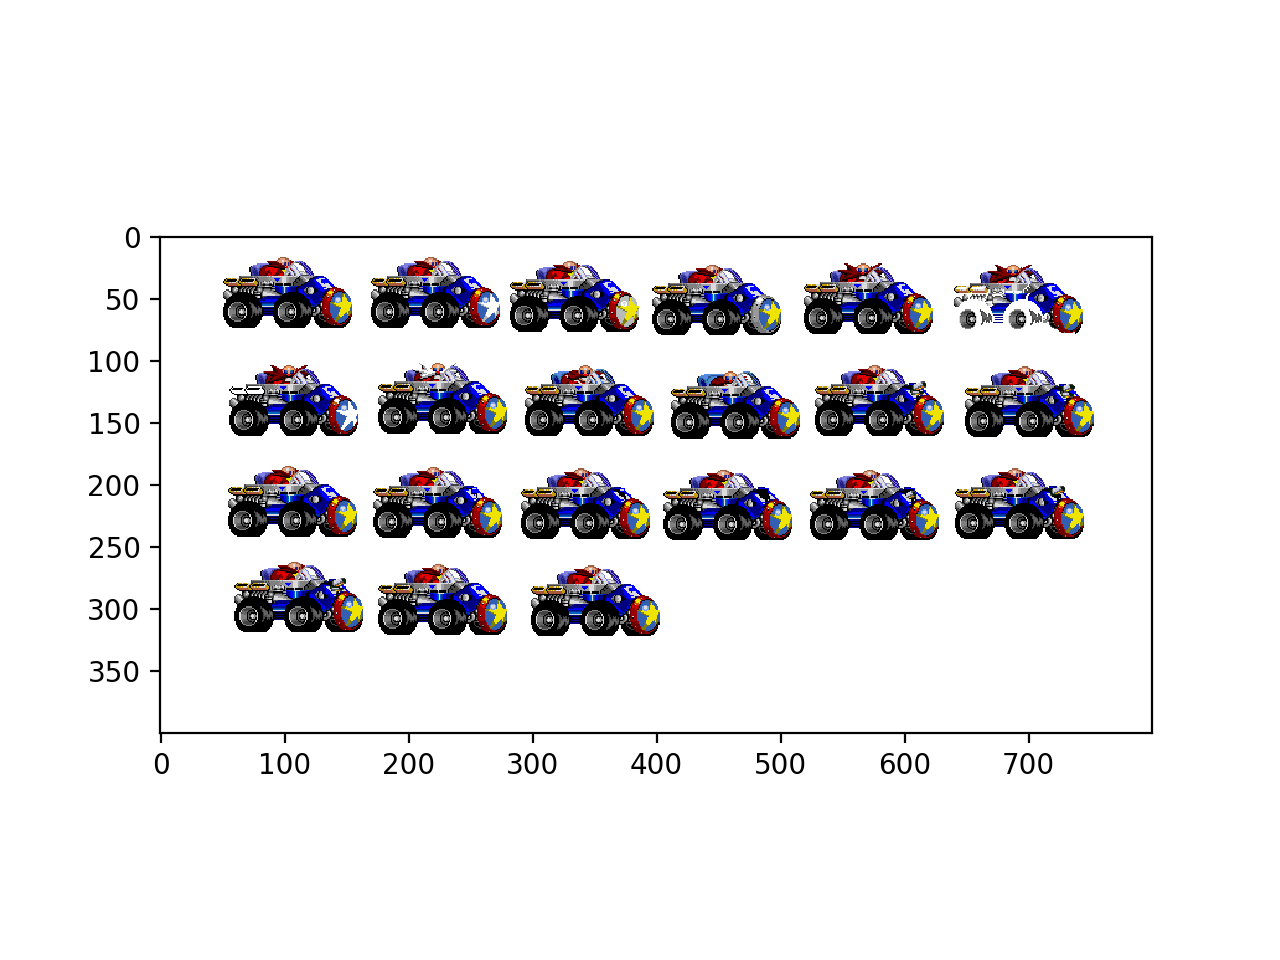

In [125]:
f = files[3]
im = np.array(Image.open(f))
plt.close('all')
plt.imshow(im)

# Pre-Processing

We want to remove primary colors from the background. So we do that here.

In [11]:
def remove_color(img, color, inplace=True):
    img = np.asarray(img)
    if not inplace:
        img = img.copy()
    alpha = (~np.all(img[:,:,:3]==color[:3], axis=2))
    if img.shape[2]==4:
        img[:,:,3] *= alpha
    else:
        img = np.dstack((img, alpha*255))
    return img

<IPython.core.display.Javascript object>


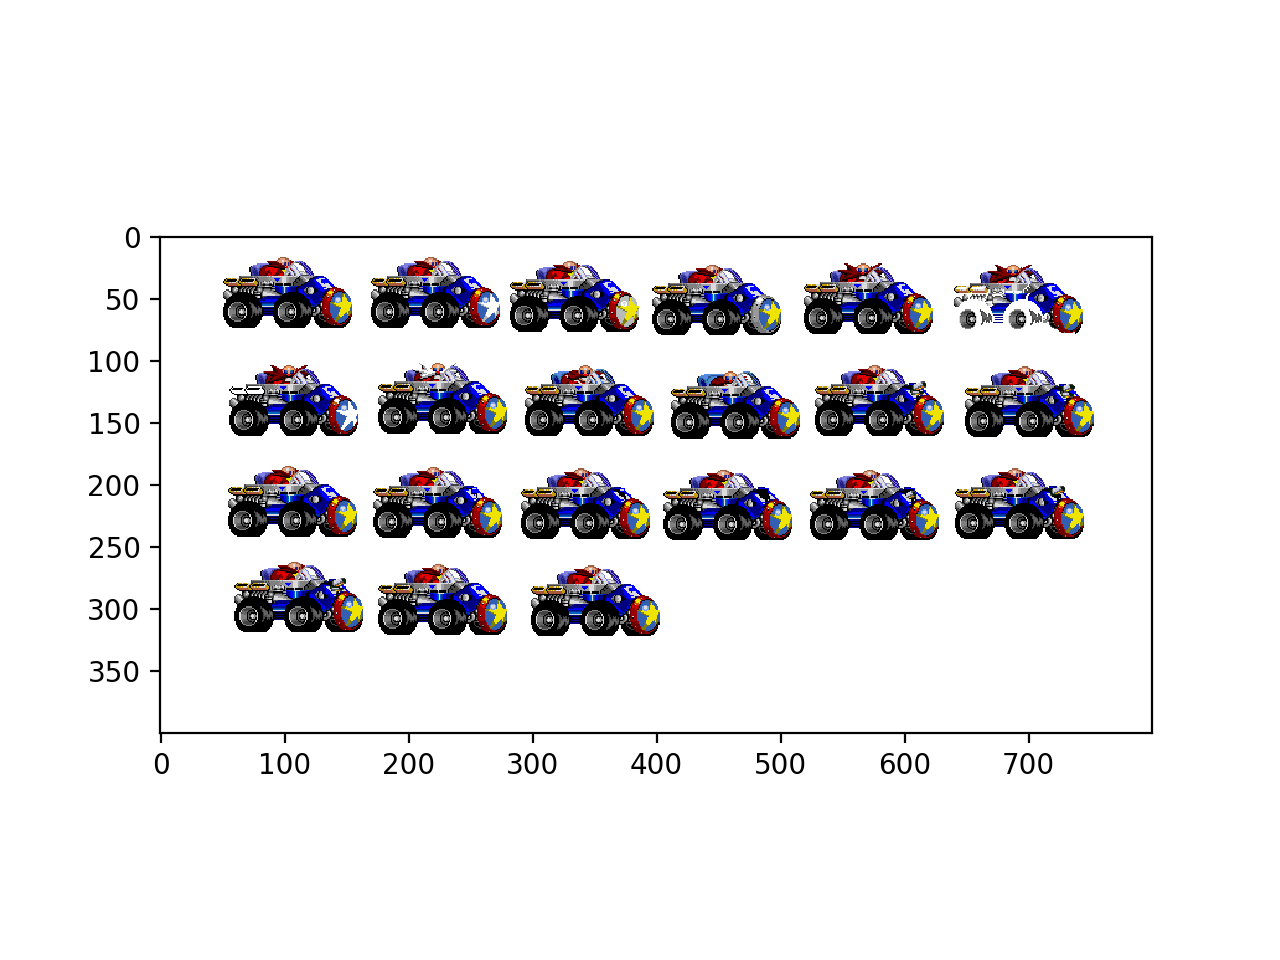

In [128]:
im = remove_color(im, im[0,0,:], inplace=False)
plt.close('all')
plt.imshow(im)

We also want to remove anything which is noisy in the image, like text. So we go to the image and remove regions by covering them with high alpha.

In [12]:
def remove_region(img, region: Region, inplace=True):
    img = np.asarray(img)
    if not inplace:
        img = img.copy()
    img[region.y0:region.y1,region.x0:region.x1,3] = 0
    return img

<IPython.core.display.Javascript object>


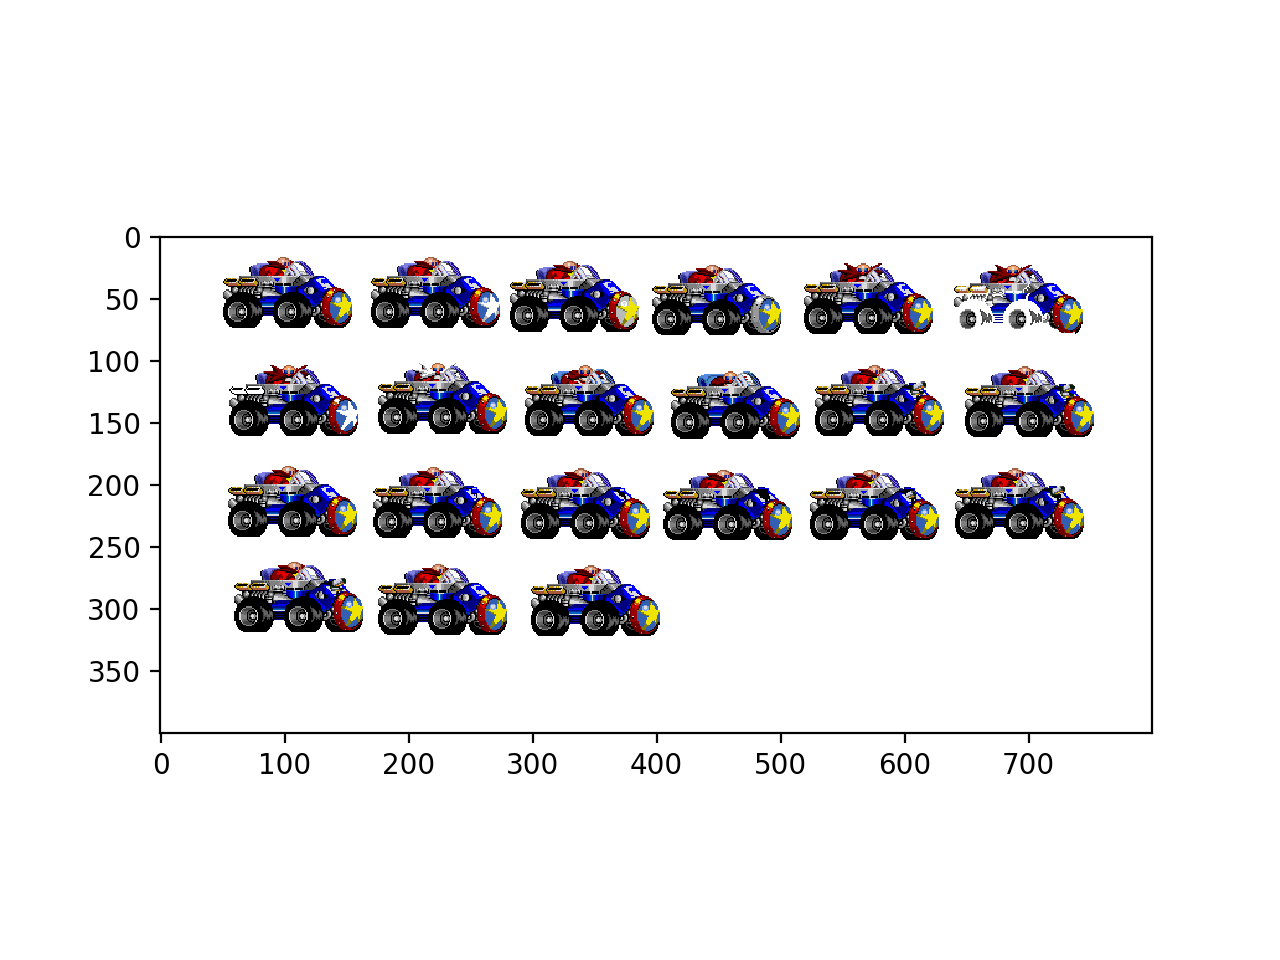

In [129]:
im = remove_region(im, Region(425,250,750,375), inplace=False)
plt.close('all')
plt.imshow(im)

# Clustering

We are going to use clustering to detect the sprites

## Convert to Scatter Plot

First we convert the image to a scatter representation.

<IPython.core.display.Javascript object>


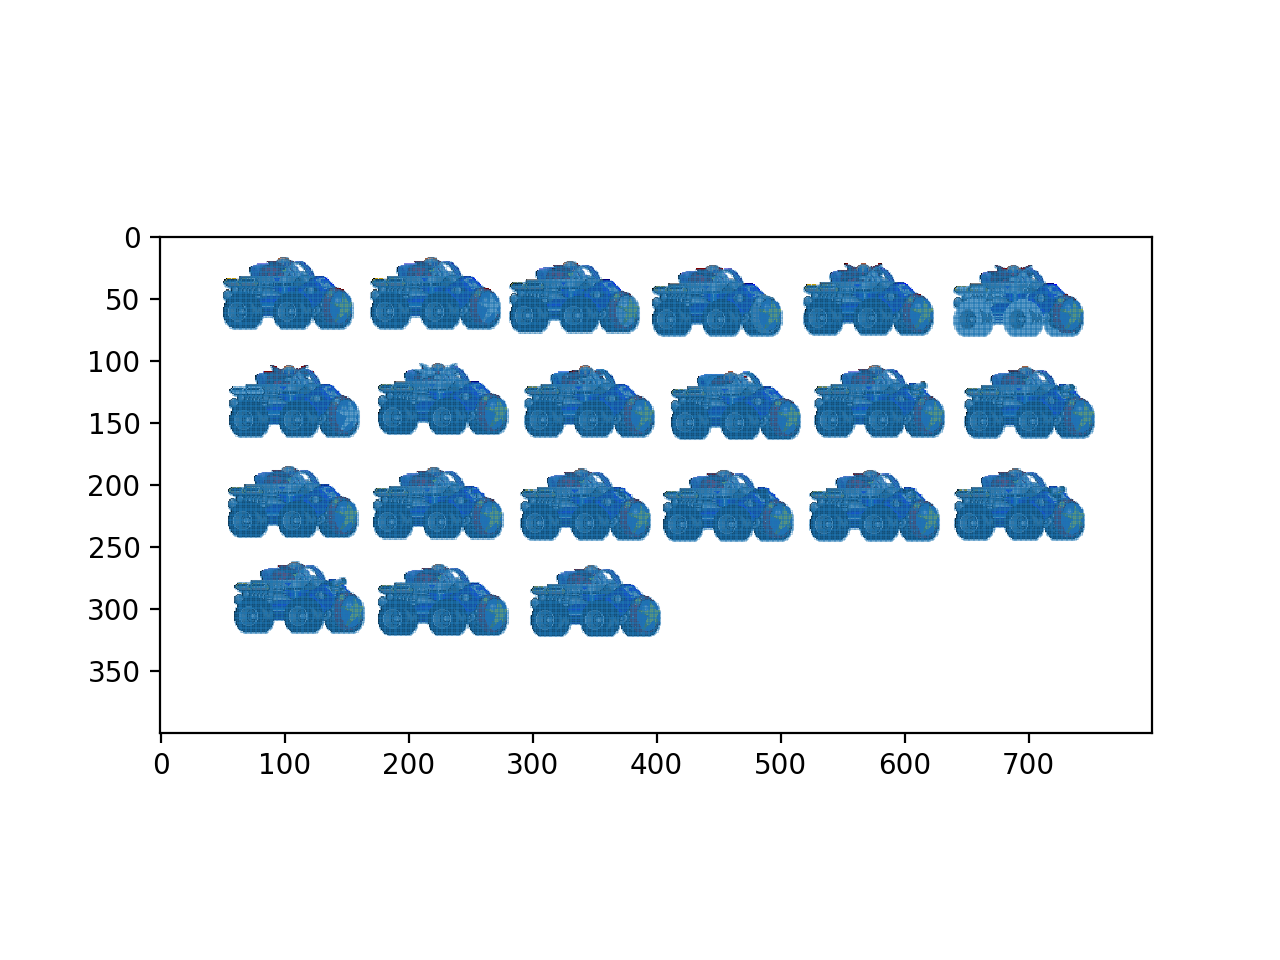

In [130]:
im_scatter_y, im_scatter_x = np.where(im[:,:,3]==255)
plt.close('all')
plt.scatter(im_scatter_x, im_scatter_y, s=.01)
plt.imshow(im)

Now we define our clustering pipeline.

In [131]:
cluster = Pipeline([('clustering', DBSCAN(2.))])

And our data.

In [132]:
X = np.vstack((im_scatter_x, im_scatter_y)).T
X.shape

(92689, 2)

We fit the cluster and get the number of clusters.

In [133]:
cluster.fit(X)
core_samples_mask = np.zeros_like(cluster.named_steps['clustering'].labels_, dtype=bool)
core_samples_mask[cluster.named_steps['clustering'].core_sample_indices_] = True
labels = cluster.named_steps['clustering'].labels_
unique_labels = np.unique(labels)
print("n clusters:", len(unique_labels))

n clusters: 21


## Plotting Clusters

Now we plot it to check that it's right.

In [13]:
# REF: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
def plot_clusters(img, X, core_samples_mask, all_labels, colors):
    unique_labels = np.unique(all_labels)
    fig, ax = plt.subplots()
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (all_labels == k)

        xy = X[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], markerfacecolor=tuple(col), markersize=1, alpha=.5)

    ax.imshow(img, alpha=.5)
    return ax

<IPython.core.display.Javascript object>


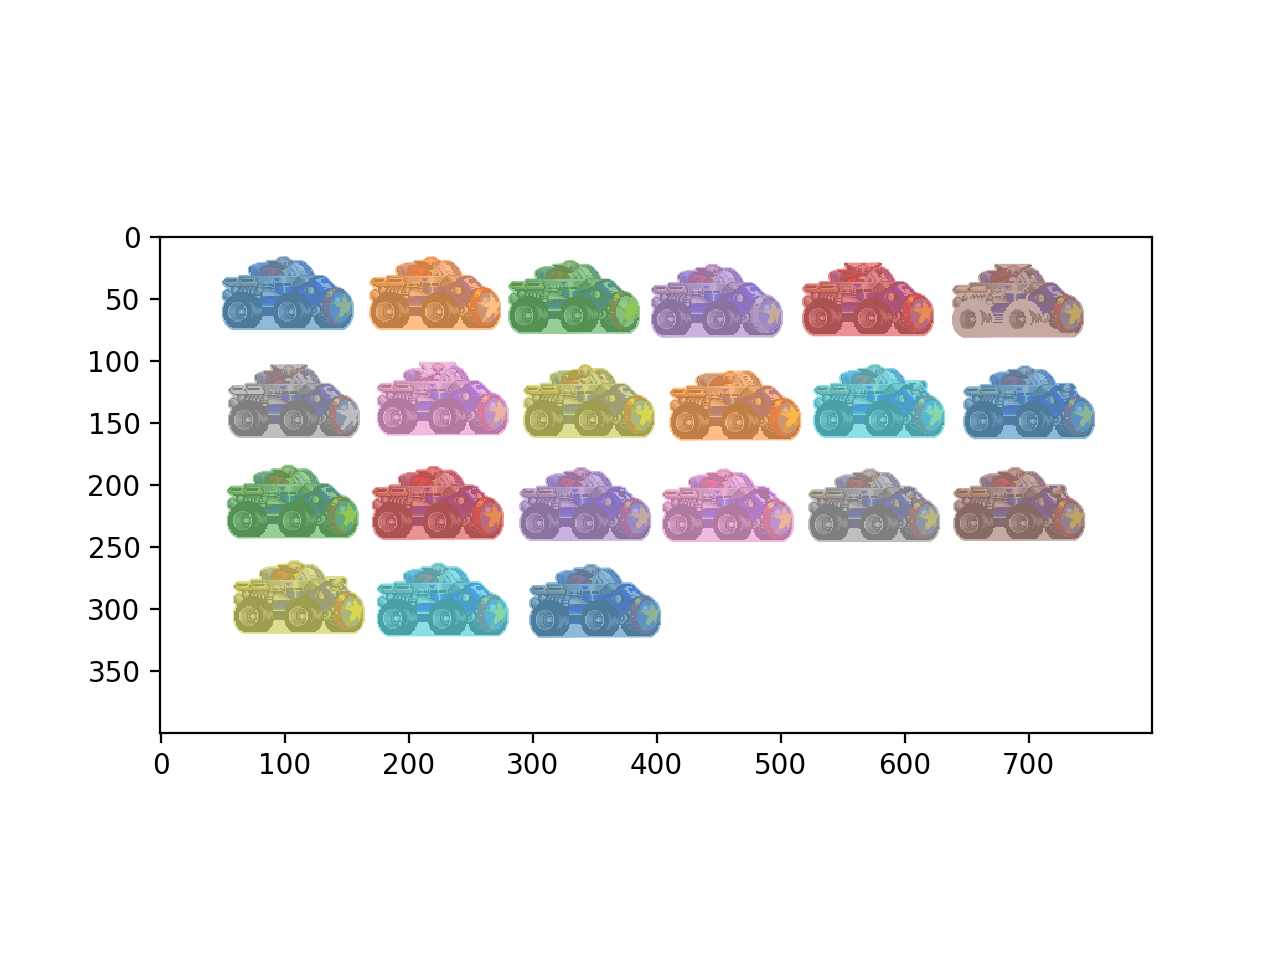

In [135]:
plt.close('all')
colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
plot_clusters(im,
              all_labels=labels,
              X=X,
              core_samples_mask=core_samples_mask,
              colors=colors)

## Bounding Boxes

Now for each cluster we get the bounding box.

In [14]:
def get_sprite(X,
               core_samples_mask,
               all_labels,
               given_label,
               color,
               x_pad=2,
               y_pad=2):
    class_member_mask = (all_labels == given_label)
    xy = X[class_member_mask & core_samples_mask]
    return Region(x0=max(0,np.min(xy[:, 0])-x_pad),
                  y0=max(0,np.min(xy[:, 1])-y_pad),
                  x1=min(np.max(X[:, 0]), np.max(xy[:, 0])+x_pad),
                  y1=min(np.max(X[:, 1]), np.max(xy[:, 1])+y_pad))
    

In [137]:
plt.close('all')
sprite_regions = [get_sprite(X=X,
                             core_samples_mask=core_samples_mask,
                             all_labels=labels,
                             given_label=k,
                             color=col) for k, col in zip(unique_labels, colors) if k != -1]
sprite_regions

[BoundingBox(x0=49, y0=15, x1=156, y1=75),
 BoundingBox(x0=168, y0=15, x1=275, y1=75),
 BoundingBox(x0=280, y0=18, x1=387, y1=78),
 BoundingBox(x0=517, y0=20, x1=624, y1=80),
 BoundingBox(x0=395, y0=21, x1=502, y1=81),
 BoundingBox(x0=638, y0=21, x1=745, y1=81),
 BoundingBox(x0=174, y0=100, x1=281, y1=160),
 BoundingBox(x0=54, y0=102, x1=161, y1=162),
 BoundingBox(x0=292, y0=102, x1=399, y1=162),
 BoundingBox(x0=526, y0=102, x1=633, y1=162),
 BoundingBox(x0=647, y0=103, x1=752, y1=163),
 BoundingBox(x0=410, y0=107, x1=517, y1=164),
 BoundingBox(x0=53, y0=183, x1=160, y1=243),
 BoundingBox(x0=170, y0=184, x1=277, y1=244),
 BoundingBox(x0=289, y0=185, x1=396, y1=245),
 BoundingBox(x0=639, y0=185, x1=746, y1=245),
 BoundingBox(x0=404, y0=186, x1=511, y1=246),
 BoundingBox(x0=522, y0=186, x1=629, y1=246),
 BoundingBox(x0=58, y0=260, x1=165, y1=320),
 BoundingBox(x0=174, y0=262, x1=281, y1=321),
 BoundingBox(x0=297, y0=263, x1=404, y1=321)]

And we get those regions from the image.

In [15]:
def get_region(img, region: Region):
    img = np.asarray(img)
    return img[region.y0:region.y1,region.x0:region.x1]

In [139]:
sprites = [get_region(im, reg) for reg in sprite_regions]

## Plotting Sprites
Now we check them all to see if they are right.

<IPython.core.display.Javascript object>


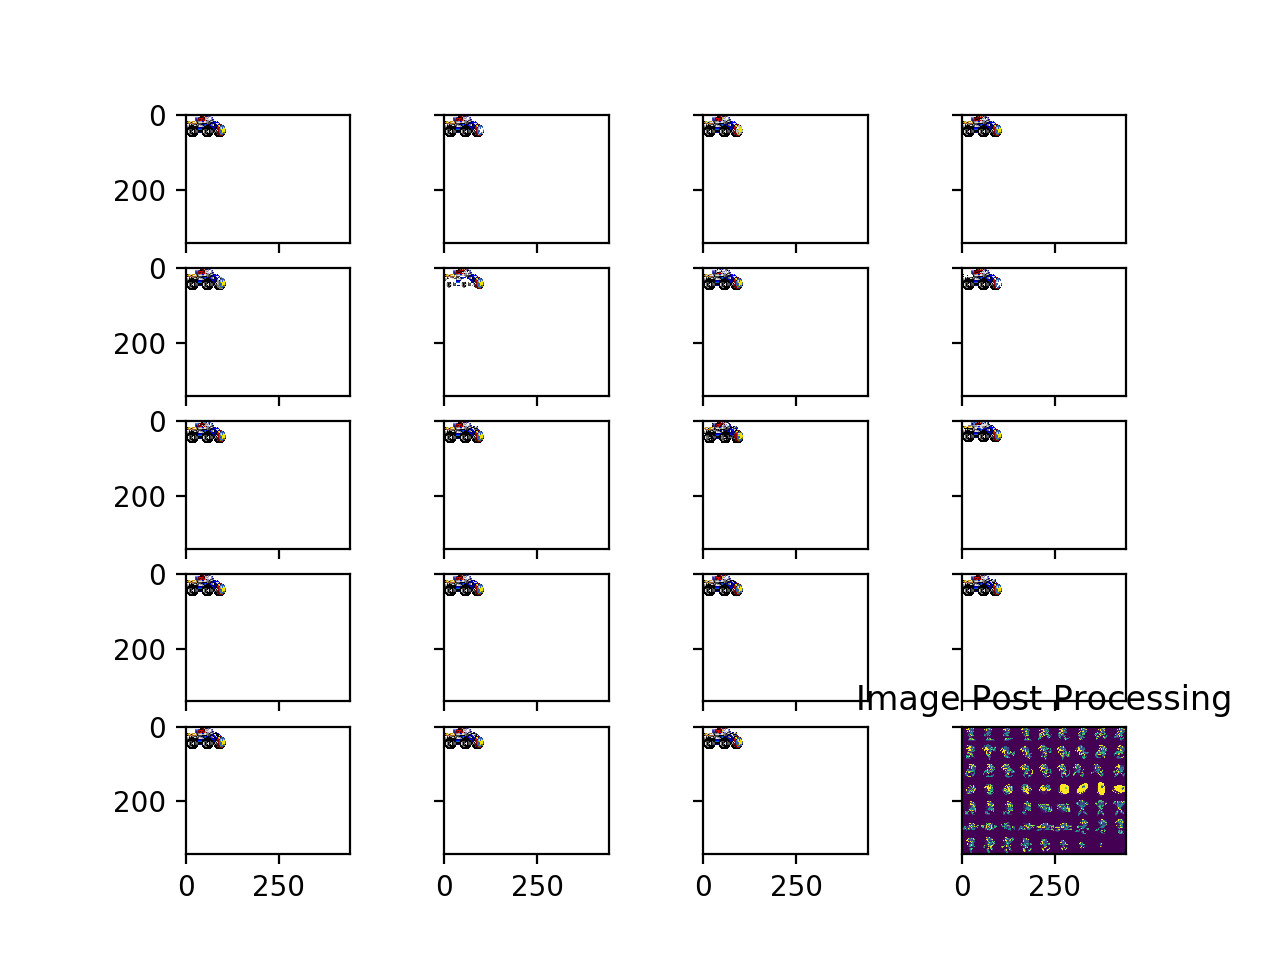

In [140]:
fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(sprites)))),
                         int(np.floor(len(sprites)/np.sqrt(len(sprites)))),
                         sharex=True, sharey=True)
j = 0
for axes_i in axes:
    for axes_j in axes_i:
        axes_j.imshow(sprites[j])
        j += 1

In [63]:
@interact(n=list(range(len(sprites))))
def draw_sprite(n):
    plt.close('all')
    plt.figure()
    plt.imshow(sprites[n])
    plt.show()

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20), value=0), Output()), _dom_classes=('widget-interact',))

## Saving

In [64]:
os.makedirs(f.parent / f.stem, exist_ok=True)
for i, sprite in enumerate(sprites):
    fname = f.parent / f.stem / (str(i) + ".png")
    imsave(fname, sprite)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


# Put it all together

In [16]:
def preprocess(f, *,
               color_locations=[],
               removal_regions=[],
               plot=True,
               save=False,
               **kwargs):
    # Get the image
    img = np.array(Image.open(f).convert("RGBA"))
    
    if plot:
        plt.figure(0)
        plt.imshow(img)
        plt.title("Image Pre Processing")
        
    # Remove Primary Colors
    for (x,y) in color_locations:
        img = remove_color(img, img[y,x,:], inplace=True)
    
    # Remove Regions
    for reg in removal_regions:
        img = remove_region(img, reg, inplace=True)
        
    if plot:
        plt.figure(1)
        plt.imshow(img)
        plt.title("Image Post Processing")
    
    # Save or return
    if save:
        os.makedirs(f.parent / f.stem, exist_ok=True)
        fname = f.parent / f.stem / (f.stem + ".png")
        imsave(fname, sprite)
    else:
        return img

In [17]:
def postprocess(img, *,
                cluster_type=DBSCAN,
                cluster_args={'eps':2., 'min_samples': 2},
                post_color_locations=[],
                x_pad=2,
                y_pad=2,
                plot=True,
                save=True,
                **kwargs):
 
    # Get the scatter data
    im_scatter_y, im_scatter_x = np.where(img[:,:,3]==255)
    X = np.vstack((im_scatter_x, im_scatter_y)).T
    
    # Get the pipeline
    cluster = Pipeline([('clustering', cluster_type(**cluster_args))])
    
    # Train the pipeline
    cluster.fit(X)
    core_samples_mask = np.zeros_like(cluster.named_steps['clustering'].labels_, dtype=bool)
    try:
        core_samples_mask[cluster.named_steps['clustering'].core_sample_indices_] = True
    except:
        core_samples_mask[:] = True
    labels = cluster.named_steps['clustering'].labels_
    unique_labels = np.unique(labels)
    print("n clusters:", len(unique_labels))
    
    # Plot the clusters
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    if plot:
        ax = plot_clusters(img, X=X, core_samples_mask=core_samples_mask, all_labels=labels, colors=colors)
        ax.set_title("Clusters")
    
    # Get the sprites
    sprite_regions = [get_sprite(X=X,
                                 core_samples_mask=core_samples_mask,
                                 all_labels=labels,
                                 given_label=k,
                                 color=col,
                                 x_pad=x_pad,
                                 y_pad=y_pad) for k, col in zip(unique_labels, colors) if k != -1]
    sprites = [get_region(img, reg) for reg in sprite_regions]
    
    # Remove Primary Colors
    for sprite in sprites:
        for (x,y) in post_color_locations:
            remove_color(sprite, img[y,x,:], inplace=True)
    
    if plot:
        fig, axes = plt.subplots(int(np.ceil(np.sqrt(len(sprites)))),
                                 int(np.floor(len(sprites)/np.sqrt(len(sprites)))),
                                 sharex=True, sharey=True)
        j = 0
        for axes_i in axes:
            for axes_j in axes_i:
                if j < len(sprite_regions):
                    try:
                        axes_j.imshow(sprites[j])
                    except:
                        print("Show Error:",sprite_regions[j])
                j += 1
        fig.suptitle('All Sprites')
                
    # Save or return
    if save is not None and save is not False and isinstance(save, (str, Path)):
        save = Path(save)
        os.makedirs(save, exist_ok=True)
        # Delete existing files
        for f_ in save.glob('*.png'):
            f_.unlink()
        # Create new files
        for i, sprite in enumerate(sprites):
            try:
                imsave(save / (str(i)+'.png'), sprite)
            except Exception as e:
                print("Save Error:",sprite_regions[i],e)
    else:
        return sprites

In [18]:
def main(save=True, **kwargs):
    img = preprocess(save=False, **kwargs)
    
    # If save is a bool, and is true, create a path
    if save and isinstance(save, bool):
        save = kwargs['f'].parent / kwargs['f'].stem
        
    # If save is a string, make it a path
    elif save and isinstance(save, str):
        save = Path(kwargs['save'])
        
    # If save is a path, keep it as is
    elif save and isinstance(save, Path):
        pass
    
    # Otherwise, set save to None
    else:
        save = None
        
    return postprocess(img, save=save, **kwargs)

<IPython.core.display.Javascript object>


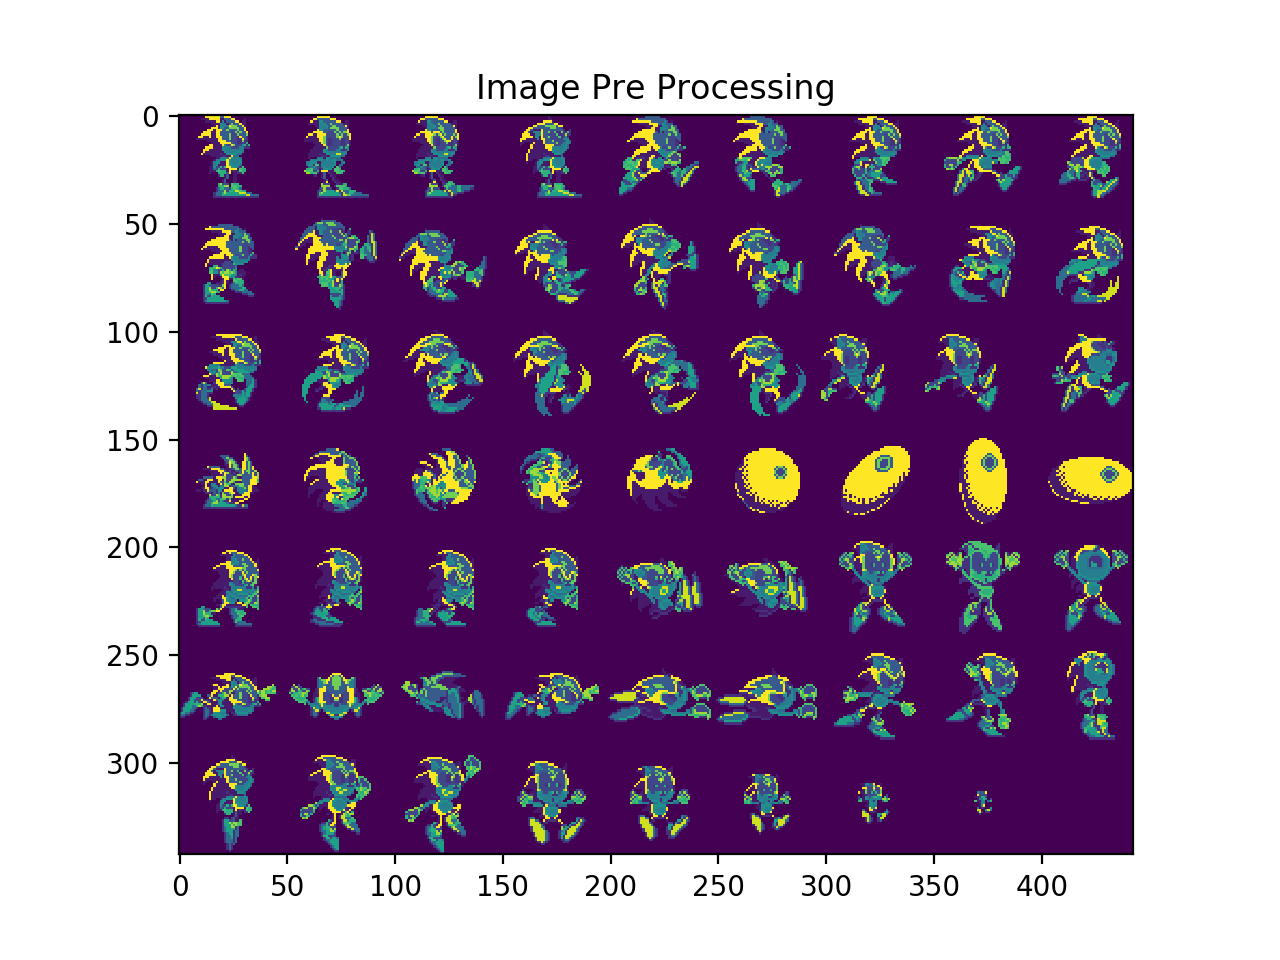

n clusters: 21


<IPython.core.display.Javascript object>


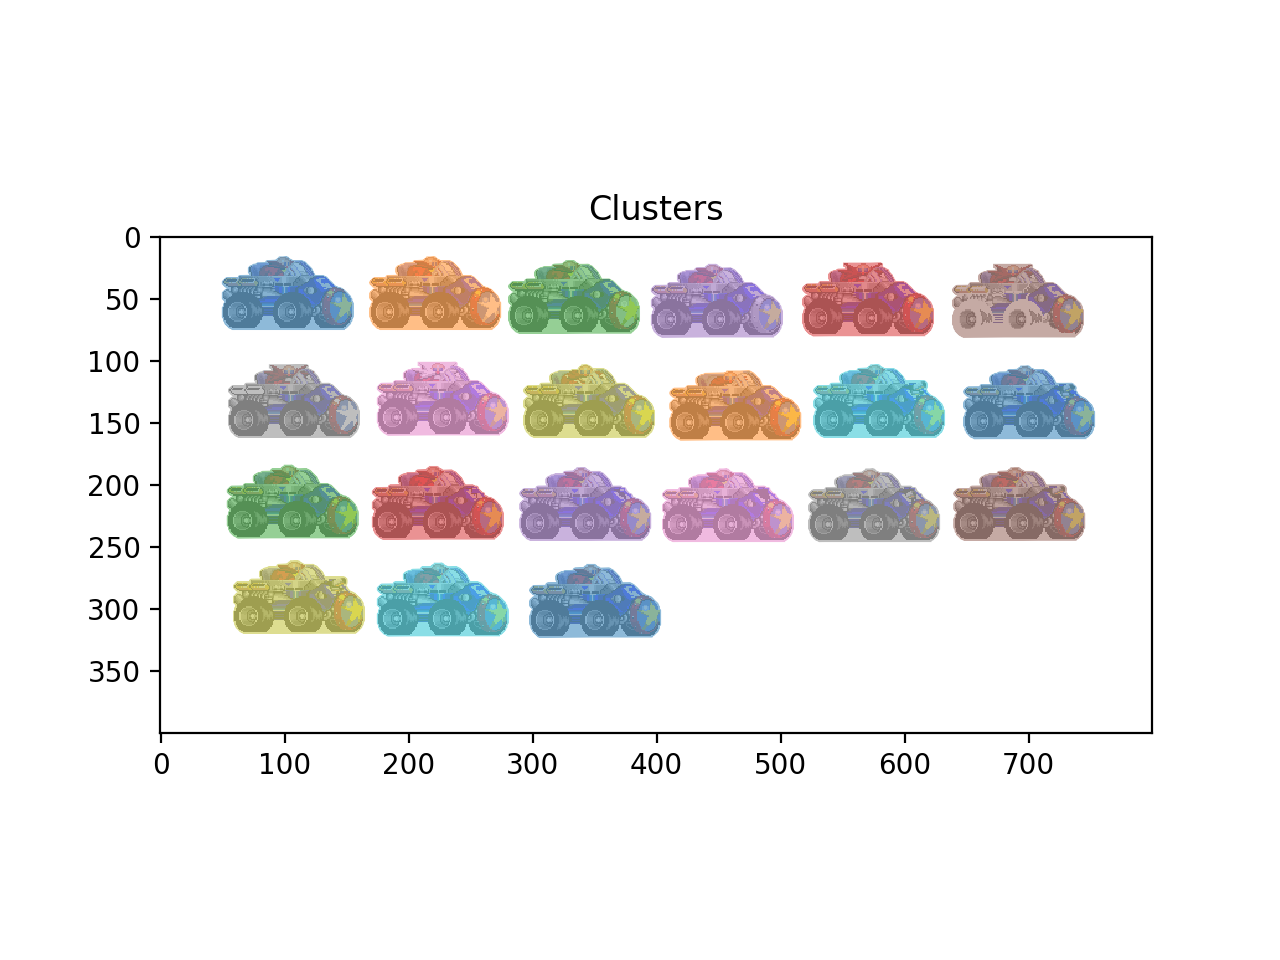

<IPython.core.display.Javascript object>


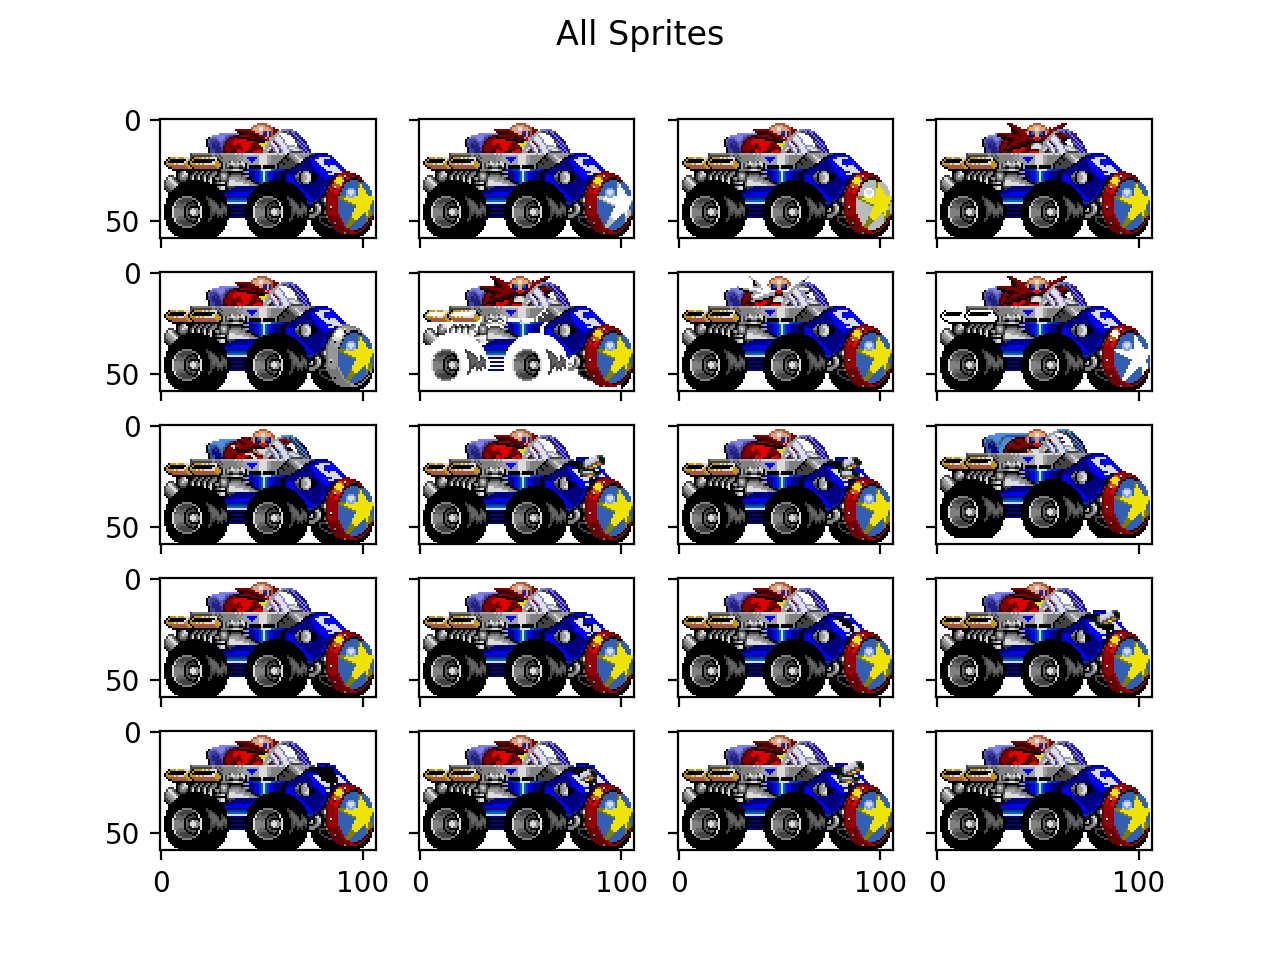

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:72: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [143]:
main(f=files[3],
     color_locations=[(0,0)],
     removal_regions=[Region(425,250,750,375)])

# Finally

Here's the tool.

In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


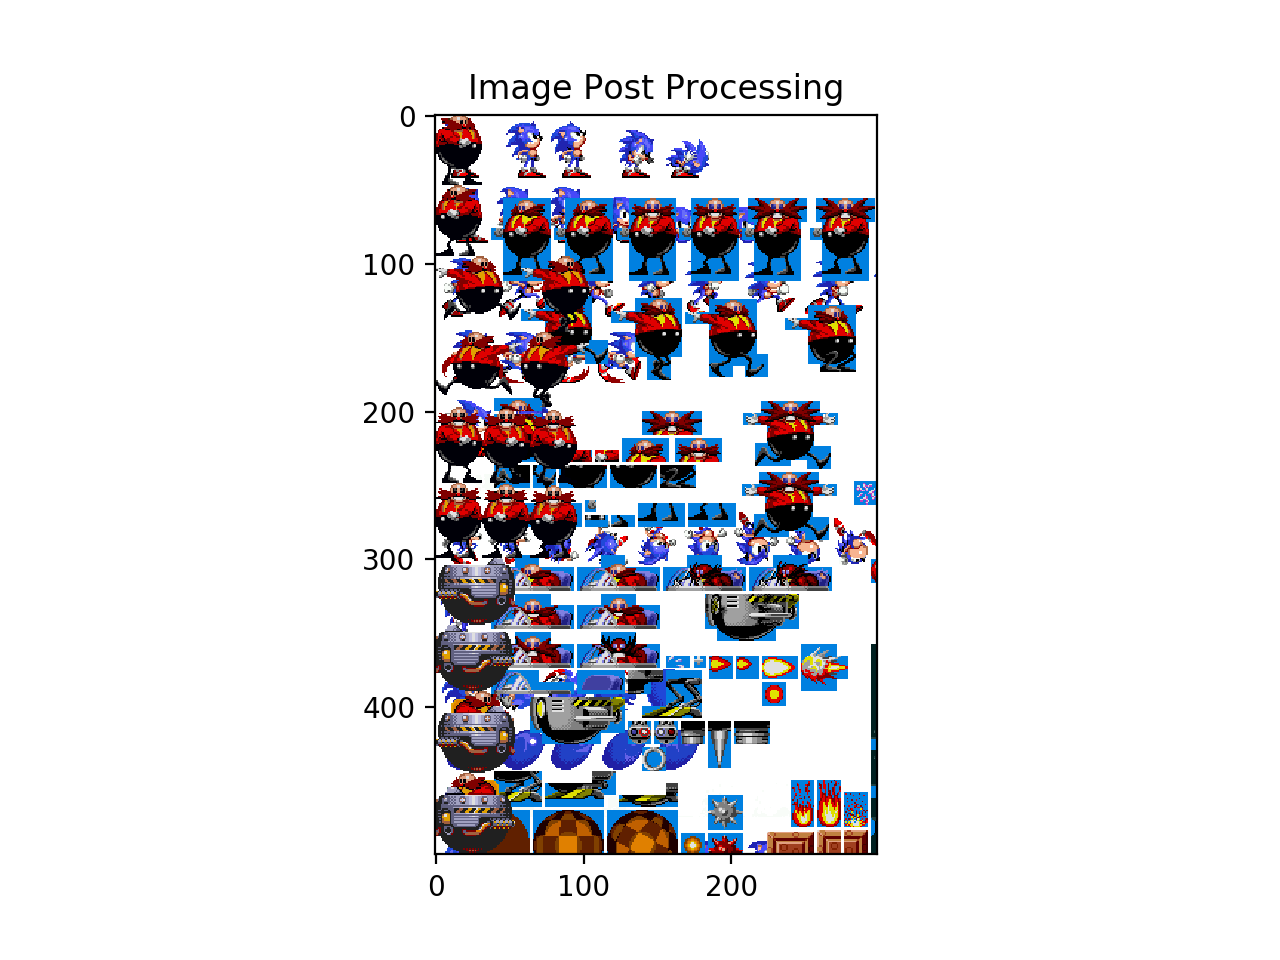

In [170]:
f=files[22]
im = np.array(Image.open(f))
plt.close('all')
plt.figure()
plt.imshow(im)
plt.show()

In [ ]:
%matplotlib inline

Run automatically on all files.

In [176]:
for f in files:
    try:
        main(f=f, plot=False)
        print("Success:", f)
    except:
        print("Error:", f)

n clusters: 141


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/dr-robotnik-12.png
n clusters: 40
Success: ../../../data/sprites/emeralds-2.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 19
Success: ../../../data/sprites/dr-robotnik-11.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 21
Success: ../../../data/sprites/dr-robotnik-10.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 52


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/eggmobile.png
n clusters: 130


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/emeralds.png
n clusters: 75
Success: ../../../data/sprites/sonic-2.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 62
Success: ../../../data/sprites/sonic-3.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 22
Success: ../../../data/sprites/sonic-7.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 44
Success: ../../../data/sprites/sonic-6.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 6
Success: ../../../data/sprites/dr-robotnik-8.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 94


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/sonic-5.png
n clusters: 87


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/shields.png
n clusters: 100


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/dr-robotnik-9.png
n clusters: 21
Success: ../../../data/sprites/sonic-10.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 94


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/sonic-8.png
n clusters: 20
Success: ../../../data/sprites/sonic-9.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 135


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/dr-robotnik.png
n clusters: 65
Success: ../../../data/sprites/goal-signs.png
n clusters: 3
Success: ../../../data/sprites/shields-2.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 4
Success: ../../../data/sprites/dr-robotnik-6.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 3
Success: ../../../data/sprites/super-sonic.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 97
Success: ../../../data/sprites/sonic-12.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 40
Success: ../../../data/sprites/item-boxes.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 62
Success: ../../../data/sprites/dr-robotnik-2.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 51
Success: ../../../data/sprites/rings.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 1
Success: ../../../data/sprites/item-boxes-2.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 63
Success: ../../../data/sprites/sonic-14.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 5
Success: ../../../data/sprites/enemies-3.png
n clusters: 144


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/explosions.png
n clusters: 130


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/items-objects.png
n clusters: 67
Success: ../../../data/sprites/misc-2.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


n clusters: 434


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Success: ../../../data/sprites/misc.png
n clusters: 84
Success: ../../../data/sprites/enemies-5.png


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Now we will run individually on the problem files.

<IPython.core.display.Javascript object>


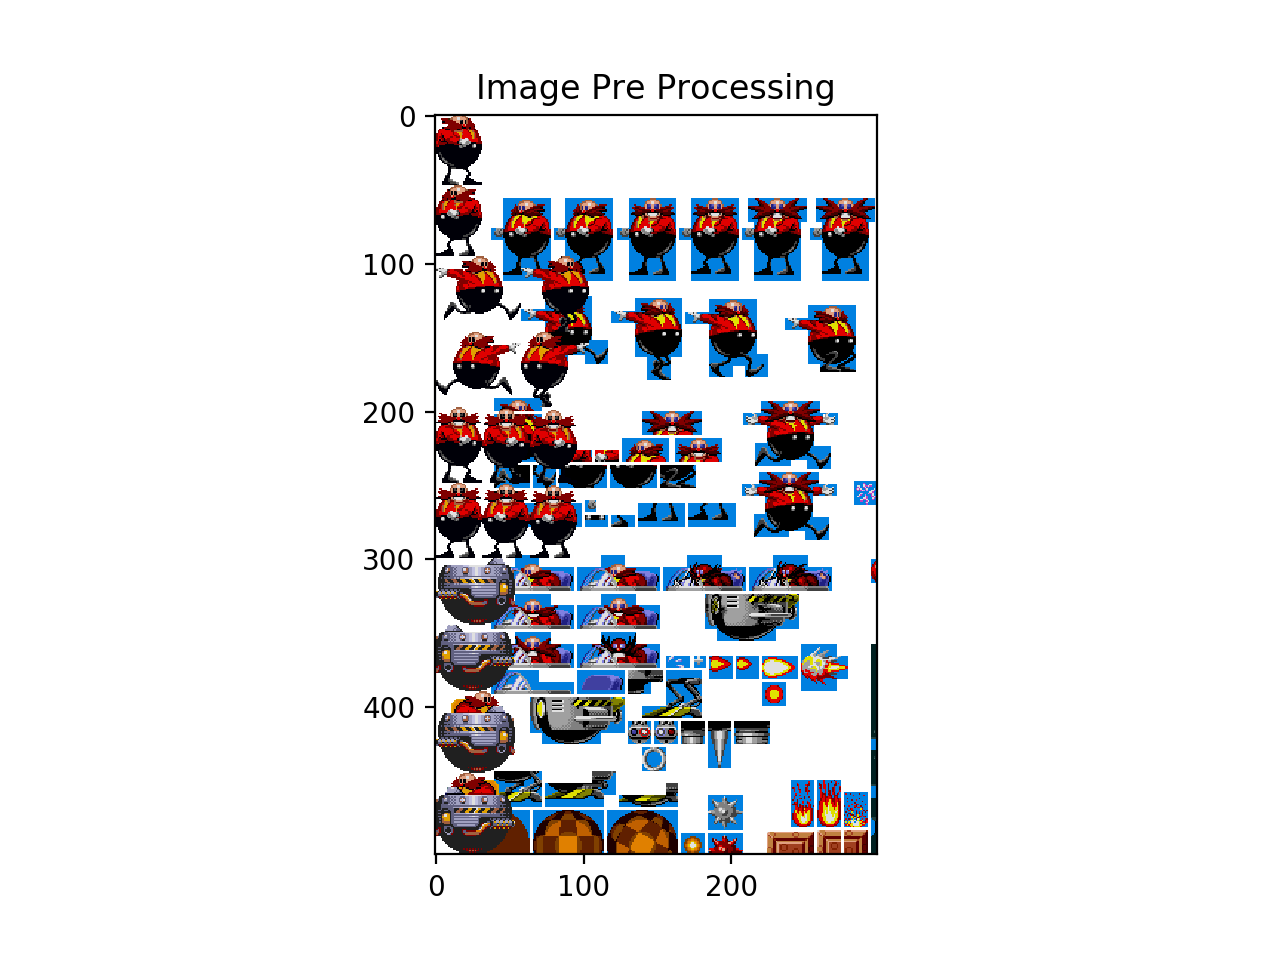

n clusters: 141


<IPython.core.display.Javascript object>


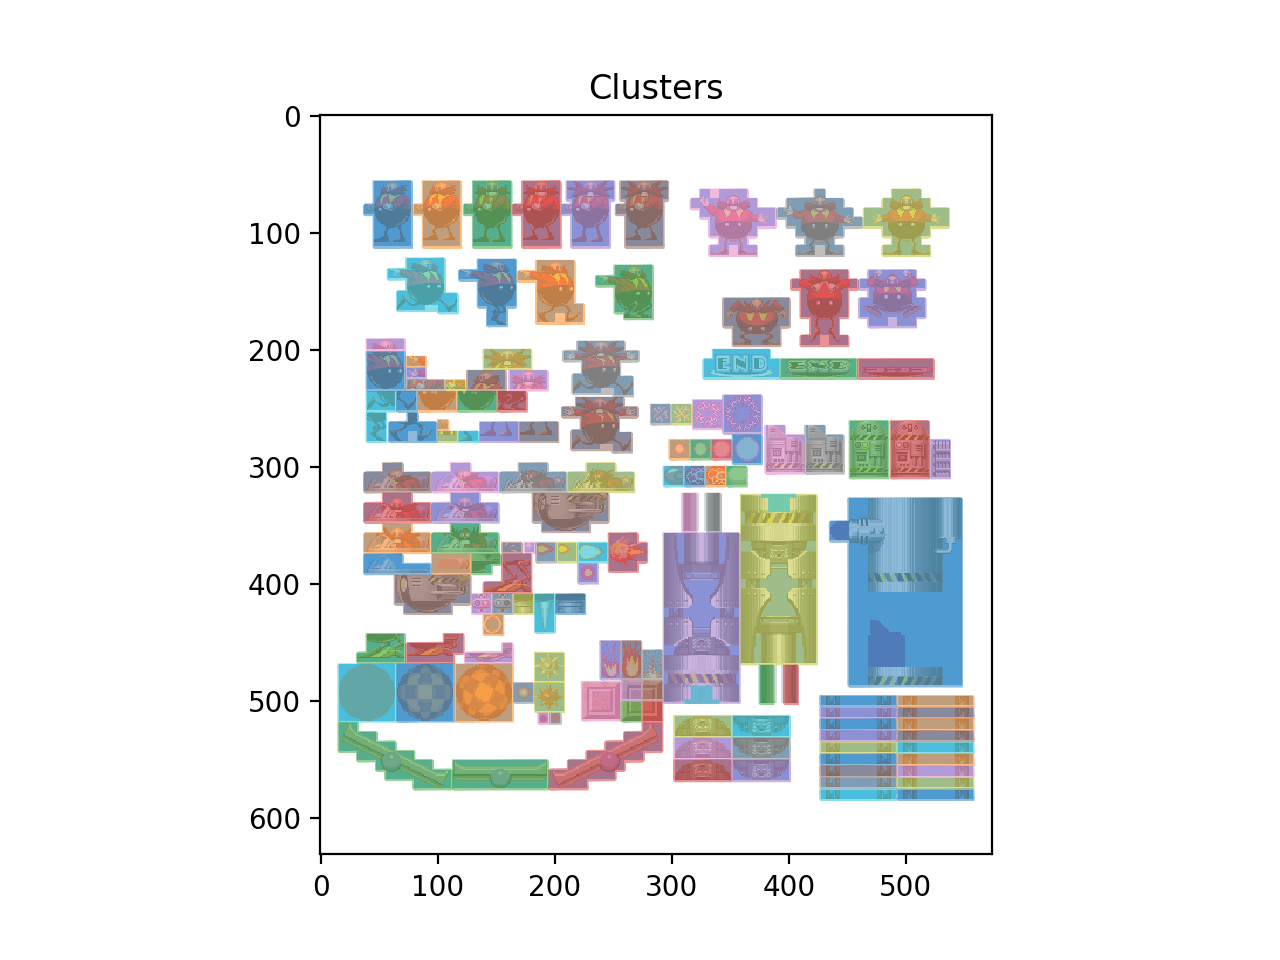

<IPython.core.display.Javascript object>


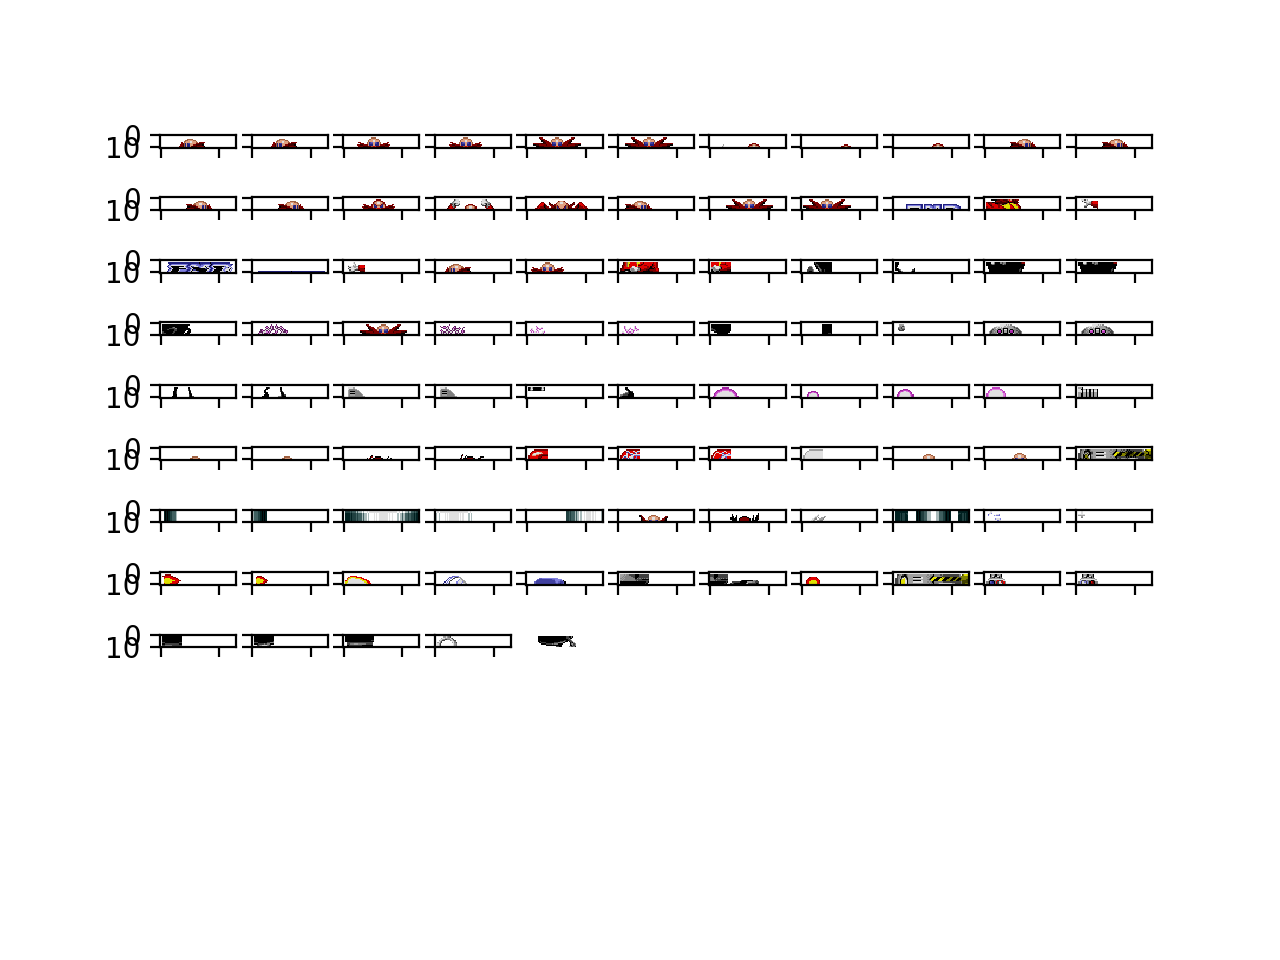

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [178]:
main(f=Path('../../../data/sprites/dr-robotnik-12.png'),
     color_locations=[],
     removal_regions=[],
     post_color_locations=[(72,164),(488,458)])

n clusters: 28


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


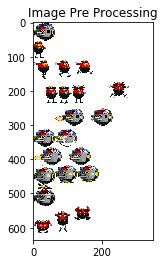

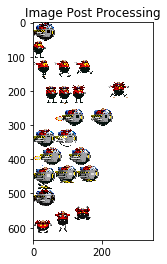

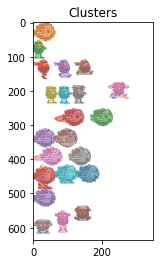

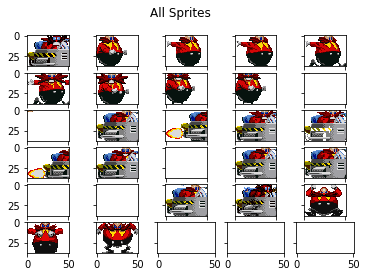

In [37]:
main(f=Path('../../../data/sprites/dr-robotnik-11.png'),
     cluster_type=DBSCAN,
     cluster_args={'eps':1.8},
     color_locations=[],
     removal_regions=[],
     post_color_locations=[],
     x_pad=0,
     y_pad=0)

n clusters: 16


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


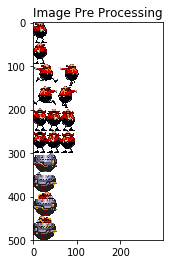

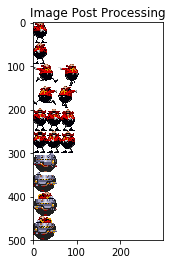

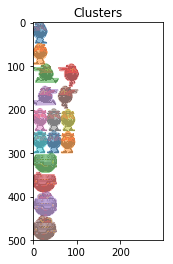

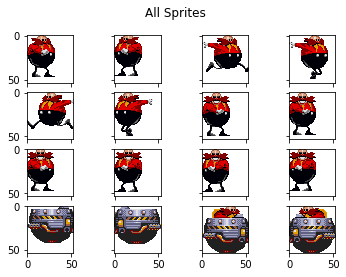

In [39]:
main(f=Path('../../../data/sprites/dr-robotnik-8.png'),
     cluster_type=DBSCAN,
     cluster_args={'eps':1.8},
     color_locations=[],
     removal_regions=[],
     post_color_locations=[],
     x_pad=0,
     y_pad=0)

n clusters: 30


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


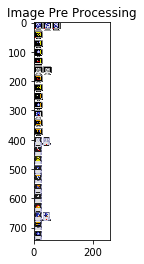

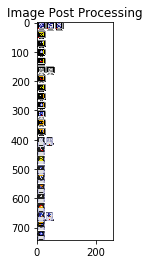

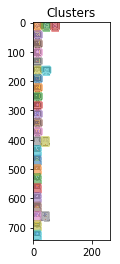

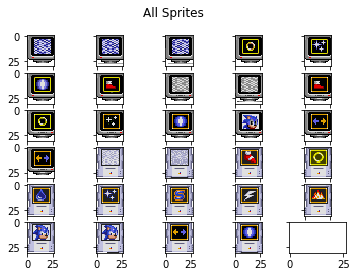

In [41]:
main(f=Path('../../../data/sprites/item-boxes-2.png'),
     cluster_type=DBSCAN,
     cluster_args={'eps':1.8},
     color_locations=[],
     removal_regions=[],
     post_color_locations=[],
     x_pad=0,
     y_pad=0)

<IPython.core.display.Javascript object>


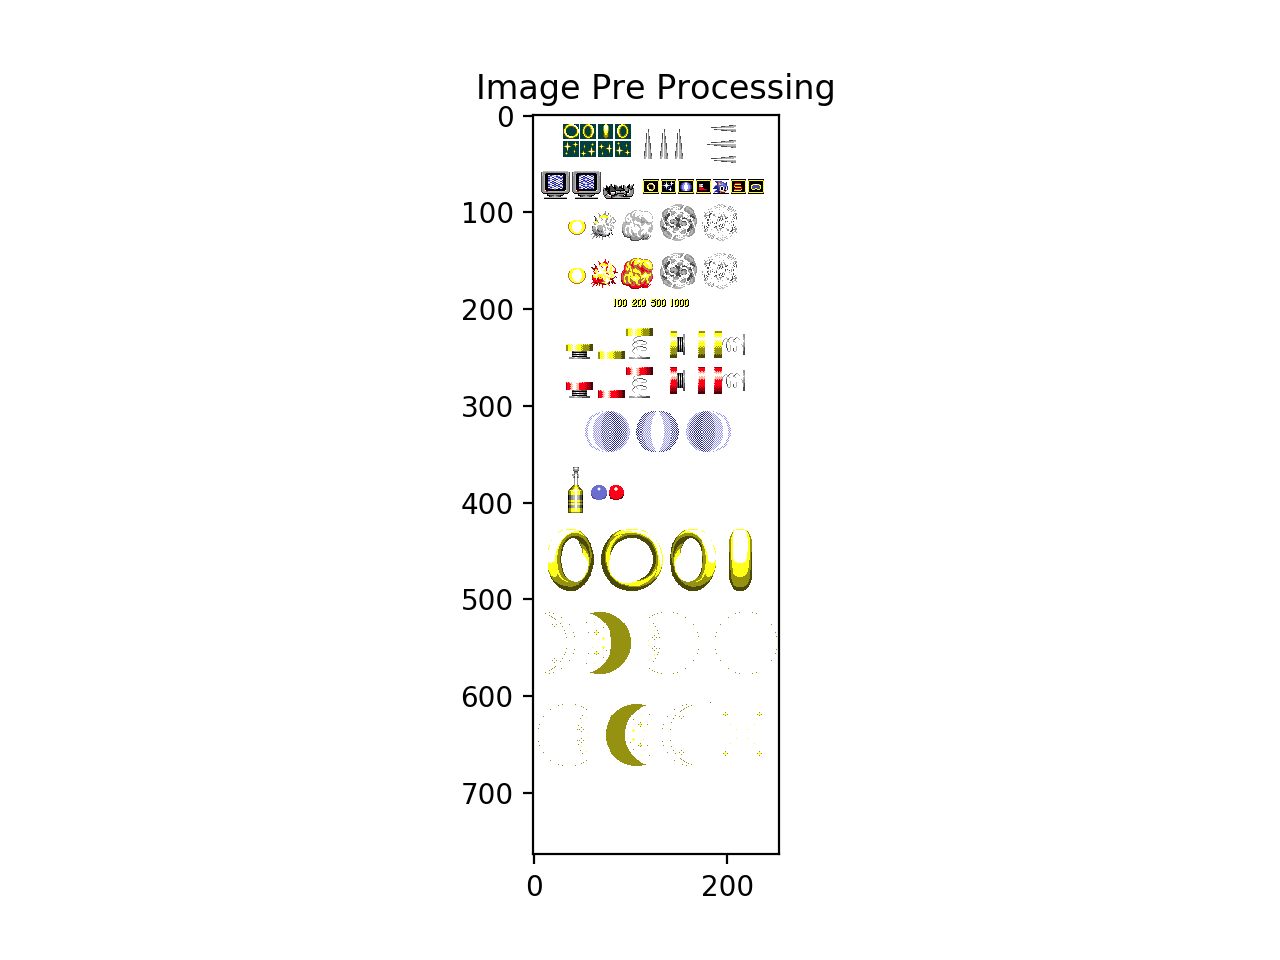

<IPython.core.display.Javascript object>


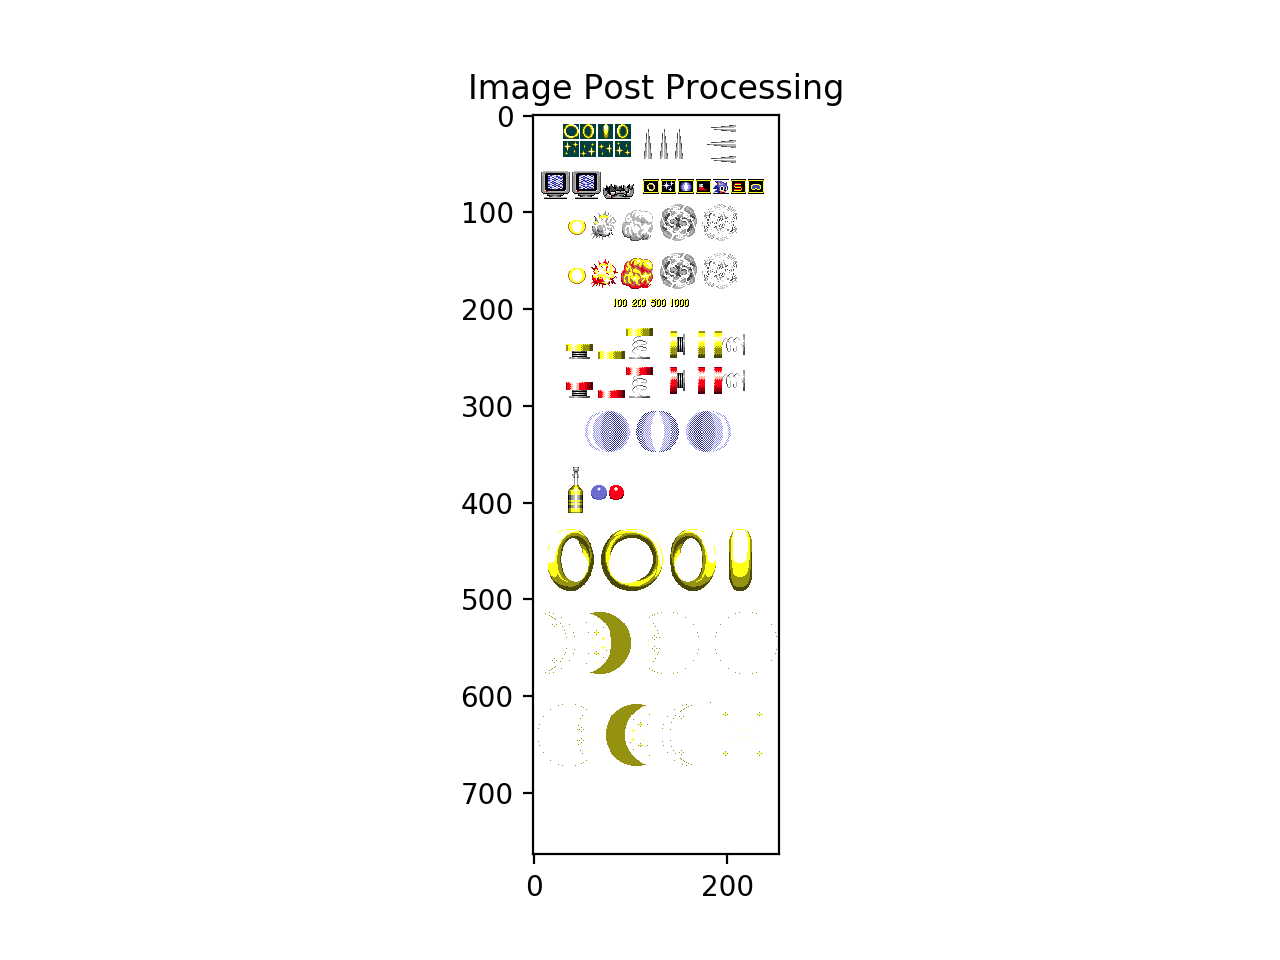

n clusters: 130


<IPython.core.display.Javascript object>


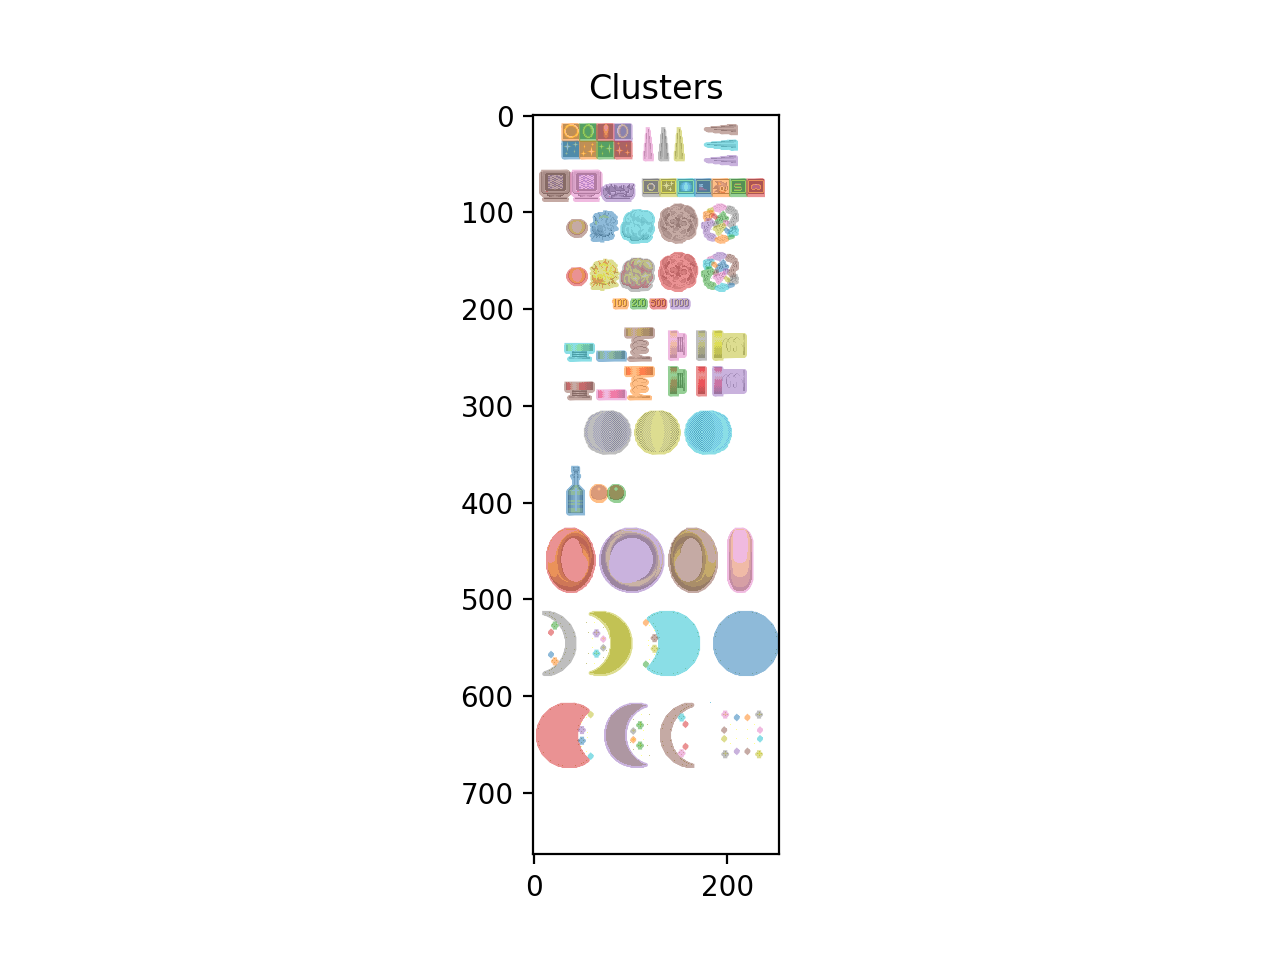

<IPython.core.display.Javascript object>


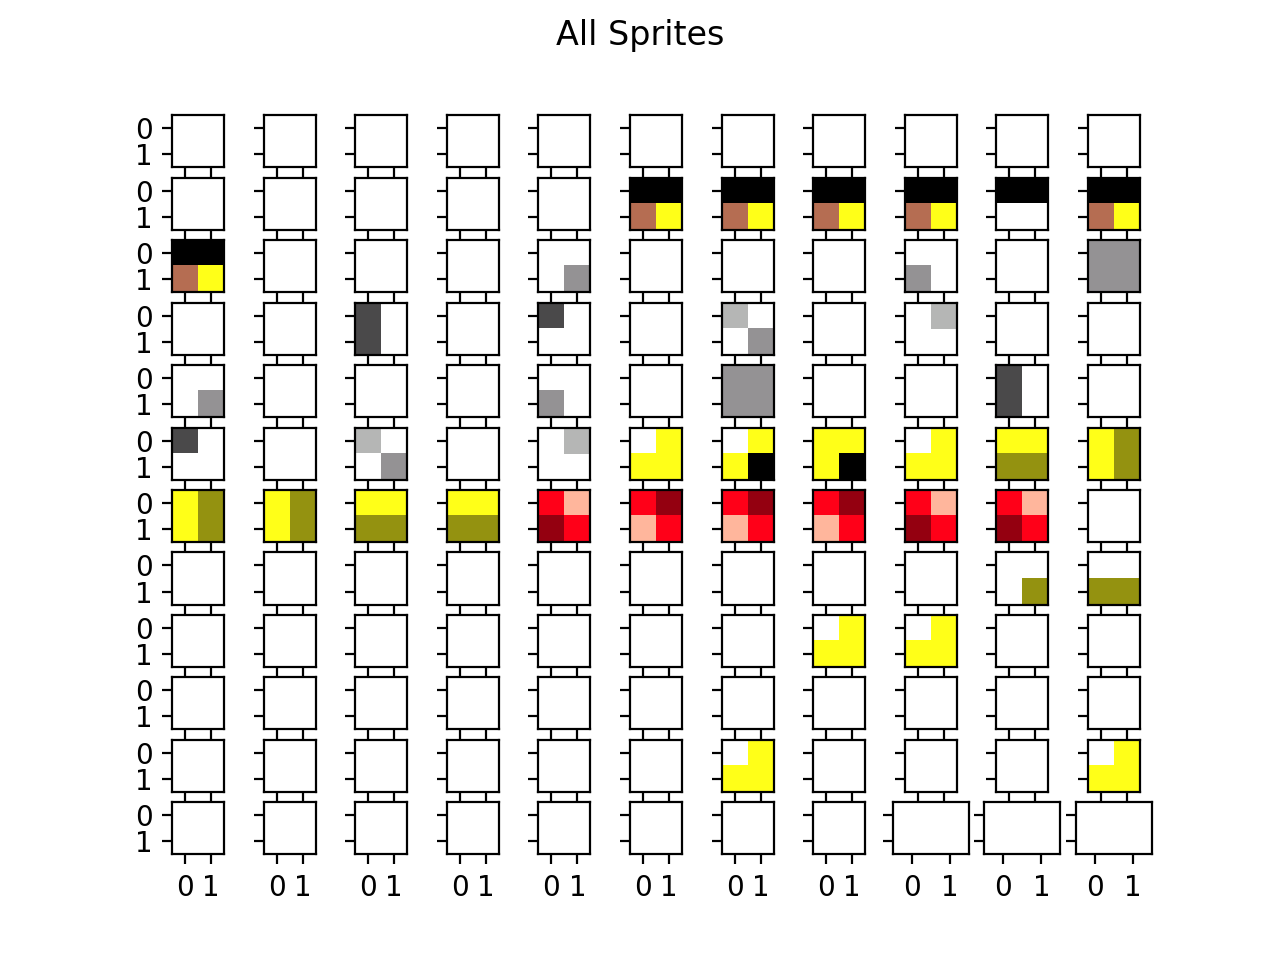

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [46]:
main(f=Path('../../../data/sprites/items-objects.png'),
     color_locations=[],
     removal_regions=[],
     post_color_locations=[(40,22)],
     x_pad=0,
     y_pad=0)